In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import PIL
from PIL import Image, ImageOps
from keras.preprocessing.image import img_to_array

In [2]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# Create & upload a text file.
# uploaded = drive.CreateFile({'title': 'Sample file.txt'})
# uploaded.SetContentString('Sample upload file content')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

# Loading Data + Inverting

In [3]:
(X_train, y_train), (_, _) = mnist.load_data()
# Configure input
X_train = (X_train.astype(np.float32) -127.5)/ 127.5 # rescaling to (-1, 1) why?
# reverse color
X_train_inv = -(X_train.astype(np.float32))
# X_train = np.expand_dims(X_train, axis=3)
#y_train = y_train.reshape(-1, 1)

11493376/11490434 [==============================] - 0s 0us/step


# Helper Functions

In [5]:
def to_255(X_train):
    """
    From (-1, 1) to (0, 255)
    """
    return np.array(X_train).astype(np.float32)*127.5+ 127.5

In [4]:
def gen_image(arr):
    """
    from (0,1) to (0, 255)
    """
    arr = np.array(arr)
    h, w = arr.shape[0], arr.shape[1]
    two_d = (np.reshape(arr, (h, w)) * 255).astype(np.uint8)
    img = Image.fromarray(two_d)
    return img

In [3]:
def plot_dist(arr):
    n, m = arr.shape[0], arr.shape[1]
    flat = arr.reshape(np.prod(arr.shape))
    plt.hist(flat)

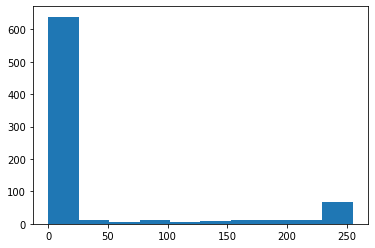

In [9]:
# This was the original scale (0, 255)
plot_dist(to_255(X_train[0]))

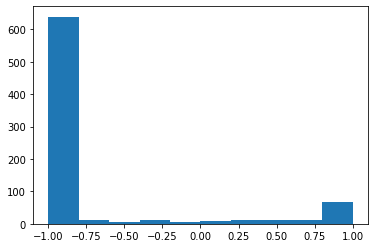

In [10]:
# Then converted to (-1, 1) as prep
plot_dist(X_train[0])

In [11]:
X_dict = {}
for i in range(10):
    X_dict[i] = X_train[y_train==i]

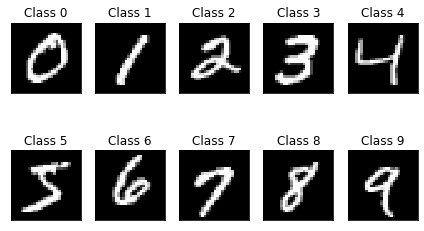

In [12]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_dict[i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

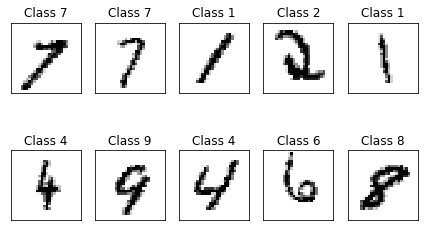

In [13]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    id = np.random.randint(0, 1000)
    #r = 18 * np.random.randint(-10, 10)
    sample = gen_image(X_train_inv[id])#.rotate(r)
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Class %d" % (y_train[id]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

# Rotation
Rotated images need for training rotation conditioning.
Two sets are created. 

1.   Random rotation (all X_train is randomly rotated once per image)
2.   Specified rotated (each X_train[i] is rotated at some fixed rotations.)



In [14]:
# rotated data for each sample (8 rotation per img) -- DONE --
X_rotated = []
y_rotated = []
y_rotations = []
num_rotation_per_img = 8
angles = [45*i for i in range(num_rotation_per_img)]
for i, img in enumerate(X_train):
    img = gen_image(img)
    label = y_train[i]
    for angle in angles:
        rotated_img = img.rotate(angle)
        img_arr = np.asarray(rotated_img)
        X_rotated.append(img_arr)
        y_rotated.append(label)
        y_rotations.append(angle)

X_rotated = np.array(X_rotated)
y_rotated = np.array(y_rotated)
y_rotations = np.array(y_rotations)

In [15]:
angles = [45*i for i in range(num_rotation_per_img)]
np.random.choice(angles, 10)

array([ 90, 225,  45, 315,  45,  90, 270, 225, 180, 180])

In [6]:
# # For pickleing
# import pickle
# with open('./drive/MyDrive/X_rotated.pickle', 'wb') as handle:
#     pickle.dump(X_rotated, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('./drive/MyDrive/y_rotated.pickle', 'wb') as handle:
#     pickle.dump(y_rotated, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('./drive/MyDrive/y_rotations.pickle', 'wb') as handle:
#     pickle.dump(y_rotations, handle, protocol=pickle.HIGHEST_PROTOCOL)

import pickle    
# To recover
with open('./drive/MyDrive/X_5_rotated.pickle', 'rb') as handle:
    X_5_rotated = pickle.load(handle)
with open('./drive/MyDrive/X_5_rotations.pickle', 'rb') as handle:
    X_5_rotations = pickle.load(handle)

In [8]:
X_5_rotations

[85, 43, 41, -48, 59, 7, -25, 72, 53, 7]

In [ ]:
# Create & upload a file.
# uploaded = drive.CreateFile({'title': './MyDrive/X_rotated.pickle'})
# uploaded.SetContentFile('/content/X_rotated.pickle') 
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [ ]:
# Rotated Image for 5  --DONE--
# X_5_rotated = []
# X_5_rotations = []
# num_rotation_per_img = 10
# for i, img in enumerate(X_dict[5]):
#     img = gen_image(img)
#     for j in range(num_rotation_per_img):
#         angle = np.random.randint(-90, 90)
#         rotated_img = img.rotate(angle)
#         img_arr = np.asarray(rotated_img)/255
#         X_5_rotated.append(img_arr)
#         X_5_rotations.append(angle)

In [ ]:
# Rotated Image for 5 (easy)  --DONE--
# rotation limited only to same increments
# X_5_rotated_easy = []
# X_5_rotations_easy = []
# num_rotation_per_img = 10
# for i, img in enumerate(X_dict[5]): 
#     img = gen_image(img)
#     for j in range(num_rotation_per_img):
#         angle = (180/num_rotation_per_img)*j
#         rotated_img = img.rotate(angle)
#         img_arr = np.asarray(rotated_img)
#         X_5_rotated_easy.append(img_arr)
#         X_5_rotations_easy.append(angle)

In [1]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    #id = np.random.randint(0, len(X_5_rotated))
    plt.imshow(X_5_rotated[i+20], cmap='gray', interpolation='none')
    #plt.title("angle %d" % (X_5_rotations[id]))
    plt.xticks([])
    plt.yticks([])
plt.show()

NameError: ignored

In [ ]:
# # For pickleing
#import pickle
# with open('X_5_rotated_easy.pickle', 'wb') as handle:
#     pickle.dump(X_5_rotated_easy, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/MyDrive/X_5_rotated_easy.pickle', 'rb') as handle:
#     X_5_rotated_easy= pickle.load(handle)

# Random Inverting

In [ ]:
# Generate samples that are randomly flipped color
X_inv_labels = [] #np.array([1 if np.random.rand() >0.5 else 0 for _ in range(len(y_train))])
X_inv = []
for i in range(len(X_train)):
    #plt.subplot(2, 5, i+1)
    if np.random.rand() > 0.5:
        X_inv.append(X_train[i])
        # plt.imshow(gen_image(X_inv[-1]), cmap='gray')
        # plt.xticks([])
        # plt.yticks([])
        X_inv_labels.append(0)
    else:
        X_inv.append(X_train_inv[i])
        # plt.imshow(gen_image(X_inv[-1]), cmap='gray')
        X_inv_labels.append(1)
        # plt.xticks([])
        # plt.yticks([])

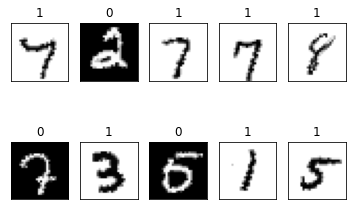

In [ ]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    id = np.random.randint(0, len(X_inv))
    plt.imshow(gen_image(X_inv[id]), cmap='gray')
    plt.title("%d" % (X_inv_labels[id]))
    plt.xticks([])
    plt.yticks([])

# Resizing
Genrating samples for size conditioning. Each sample is rotated at fixed rates (10 per image) with eaqual interval. 

In [16]:
def scale(arr):
    '''from (0,1) to (-, 1)'''
    return np.array(arr)*1.5 -0.5

In [17]:
def rescale(arr):
    X = arr.reshape((28*28,))
    MAX = np.max(X)
    MIN = np.min(X)
    min = -1
    max = 1
    rescaled =  np.array((max-min)*(arr-MIN)/(MAX-MIN) + min).reshape((28, 28, 1))
    return rescaled

In [18]:
def center_crop(img, new_width=None, new_height=None):        

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

In [19]:
cropped = gen_image(center_crop(X_train[5], 18, 18))
cropped.resize((28, 28))

In [20]:
def resize(img, factor):
    """
    INPUT: img: input image, (28, 28), factor: int, range(-10, 10)
    """
    desired_size = 28
    new_size = (desired_size+factor,desired_size+factor)
    im = img.resize(new_size)
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    return ImageOps.expand(im, padding)

img = gen_image(X_train[0])  
# zoom in by 10 px
resize(img, 10)

In [21]:
# zoom out by 10px
resize(img, -10)

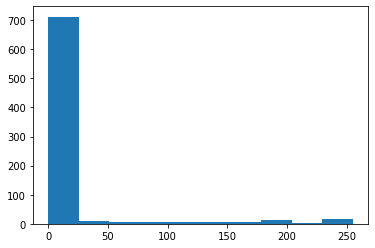

In [22]:
# Distribution is kept at (0,255)
plot_dist(np.array(resize(img,-10)))

In [23]:
# gradienting on size on the entire set X_train[2]
#from PIL import ImageEnhance
(X_train, y_train), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) -127.5)/ 127.5 # rescaling to (-1, 1)
X_2_resized = []
X_2_resizing = []
cond_list = np.array([i*2 for i in range(-5, 6)])  # range (-10, 10)
X_2_train = X_train[y_train==2]
for i in range(len(X_2_train)):
    img = gen_image(X_2_train[i])
    for cond in cond_list:
        X_2_resized.append(np.array(resize(img,cond)))
        X_2_resizing.append(cond)

In [24]:
def center(arr):
    return (np.array(arr).astype(np.float32) -127.5)/ 127.5

([], <a list of 0 Text major ticklabel objects>)

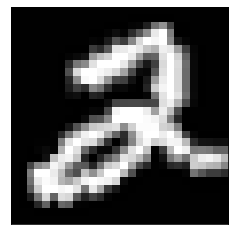

In [36]:
#gen_image(center(X_2_resized)[9])
plt.imshow(center(X_2_resized)[9], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
# fig = plt.figure()
# for i in range(10):
#     plt.subplot(2, 5, i+1)
#     id = np.random.randint(0, len(X_5_rotated_easy))
#     plt.imshow(X_5_rotated_easy[id], cmap='gray', interpolation='none')
#     #plt.title("angle %d" % (X_5_rotations[id]))
#     plt.xticks([])
#     plt.yticks([])

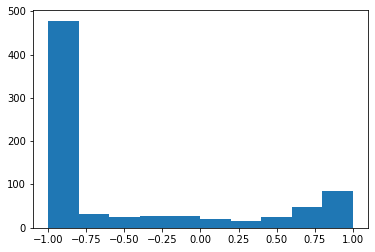

In [26]:
# distribution is (-1, 1 ) adjusted
plot_dist(center(X_2_resized)[9])

In [27]:
# import pickle
# with open('./drive/MyDrive/X_2_resized.pickle', 'wb') as handle:
#     pickle.dump(X_2_resized, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('./drive/MyDrive/X_2_resizing.pickle', 'wb') as handle:
#     pickle.dump(X_2_resizing, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Rotation + Resizing
For two continuous conditioning, data is generated for 2 factors, rotation and size.  
We generate 5 rotations and 5 sizing per image

In [ ]:
from PIL import ImageEnhance
(X_train, y_train), (_, _) = mnist.load_data()
X_7_rotated_resized = []
X_7_rotation = []
X_7_resizing = []
rotations = np.array([i*5 for i in range(-2, 3)])
X_7_train = X_train[y_train==7]
for i in range(len(X_2_train)):
    img = gen_image(X_2_train[i])
    for cond in cond_list:
        X_2_resized_EASY.append(np.array(resize(img,cond)))
        X_2_resizing_EASY.append(cond)

In [ ]:
from PIL import ImageEnhance
(X_train, y_train), (_, _) = mnist.load_data()  # (0, 255)
rotations = np.array([i*45 for i in range(-2, 3)])
resizings = np.array([i*5 for i in range(-2, 3)])
X_7_rotated_resized = []
X_7_rotations = []
X_7_resizings = []
num_rotation_per_img = 10
X_7_train = X_train[y_train==7]/255             # (0, 1)
for i, img in enumerate(X_7_train): 
    img = gen_image(img)                        # (0, 255)
    for rotation in rotations:
        rotated_img = img.rotate(rotation)
        for resizing in resizings:
            img_arr = np.asarray(resize(rotated_img, resizing))
            X_7_rotated_resized.append(img_arr)
            X_7_rotations.append(rotation)
            X_7_resizings.append(resizing)
X_7_rotated_resized = center(X_7_rotated_resized)

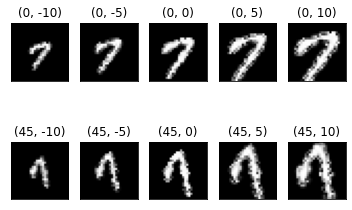

In [ ]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    i+=10
    im = X_7_rotated_resized[i]
    img = gen_image(im)
    plt.imshow(img, cmap='gray')
    plt.title((X_7_rotations[i],X_7_resizings[i]))
    plt.xticks([])
    plt.yticks([])

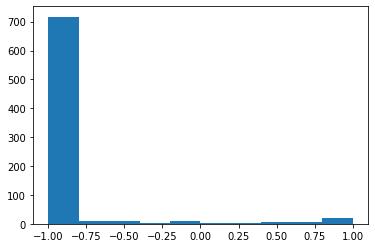

In [ ]:
plot_dist(X_7_rotated_resized[0])

In [ ]:
import pickle
with open('X_7_rotated_resized.pickle', 'wb') as handle:
    pickle.dump(X_7_rotated_resized, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('X_7_rotations.pickle', 'wb') as handle:
    pickle.dump(X_7_rotations, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('X_7_resizings.pickle', 'wb') as handle:
    pickle.dump(X_7_resizings, handle, protocol=pickle.HIGHEST_PROTOCOL)